In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold,ShuffleSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import random
from sklearn.ensemble import RandomForestClassifier
#載入所需套件

In [2]:
#載入train.csv，並且分成y(output)和x(input)
df=pd.read_csv('train.csv')
dy=df['Exited']
dx=df[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]

#使用get_dummies將類別型資料轉成onehot型式
dX=pd.get_dummies(dx,columns=['Geography','Gender'])
feature_names=list(dX.columns)

#將資料標準化
dX_std=StandardScaler().fit_transform(dX)
dX_std[1]
dX.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,720,38,5,114051.97,2,0,1,107577.29,0,0,1,0,1
1,682,54,4,62397.41,1,1,0,113088.60,1,0,0,1,0
2,672,31,5,119903.67,1,1,1,132925.17,1,0,0,1,0
3,592,40,4,104257.86,1,1,0,110857.33,0,0,1,1,0
4,753,42,5,120387.73,1,0,1,126378.57,0,0,1,0,1


In [3]:
#把資料分割成train data, test data
dx_train,dx_test,dy_train,dy_test=train_test_split(dX_std,dy,test_size=0.2,random_state=0)
print(dx_test.shape)
print(dy_test.shape)
print(dx_train.shape)
print(dy_train.shape)

(1600, 13)
(1600,)
(6400, 13)
(6400,)


In [4]:
#分割資料，將資料分成3份，以便使用Cross-Validation的方法進行驗證
cv=StratifiedKFold(n_splits=3)

test_acc_scores=[]
test_precision_scores=[]
test_f1_scores=[]
test_final_scores=[]
para=[]
cv_acc_scores=[]
cv_precision_scores=[]
cv_f1_scores=[]
cv_final_scores=[]

In [5]:
#設定parameter矩陣，用以後續檢驗哪種超參數代入模型後的表現最好
max_depth=[2,3,4,8,9,10]
n_estimators=[100,150,300,350,400,450,500]

#for迴圈用來檢驗超參數，並使用兩種檢驗方法，一種是單純將資料分成train和test，另一種則是使用交叉驗證法
#分別計算兩種檢驗方法的accuracy, precision, f1_score，並且使用網站給定的三種權重(0.3*accuracy+0.4*precision+0.4*f1_score)算出
#兩種檢驗方法下的各個不同超參數的final_score
for m in max_depth:
    for n in n_estimators:
        model=RandomForestClassifier(max_depth=m,n_estimators=n)
        model.fit(dx_train,dy_train)
        predictions=model.predict(dx_test)
    
        test_acc_scores.append(model.score(dx_test,dy_test))
    
        precision=precision_score(dy_test, predictions)
        recall=recall_score(dy_test, predictions)
        f1_score=(2*precision*recall)/(precision+recall)
    
        test_precision_scores.append(precision)
        test_f1_scores.append(f1_score)
        test_final_scores.append(0.3*model.score(dx_test,dy_test)+0.4*precision+0.4*f1_score)
    
        para.append([m,n])       #每次跑完後記錄一次所使用的超參數，方便查找
        print([m,n])
    
        acc_sum=0
        precision_sum=0
        f1_sum=0
        final_score=0
        for train_index,test_index in cv.split(dx_train,dy_train):
            x_train=dx_train[train_index]
            x_test=dx_train[test_index]
            y_train=dy_train.iloc[train_index]
            y_test=dy_train.iloc[test_index]
        
            model.fit(x_train,y_train)
            predictions2=model.predict(x_test)
            acc_sum=acc_sum+model.score(x_test,y_test)
        
            precision2=precision_score(y_test, predictions2)
            recall2=recall_score(y_test, predictions2)
            f1_score2=(2*precision2*recall2)/(precision2+recall2)
        
            precision_sum=precision_sum+precision2
            f1_sum=f1_sum+f1_score2
            final_score=final_score+0.3*model.score(x_test,y_test)+0.4*precision2+0.4*f1_score2
    
        cv_acc_scores.append(acc_sum/3)
        cv_precision_scores.append(precision_sum/3)
        cv_f1_scores.append(f1_sum/3)
        cv_final_scores.append(final_score/3)

[2, 100]
[2, 150]
[2, 300]
[2, 350]
[2, 400]
[2, 450]
[2, 500]
[3, 100]
[3, 150]
[3, 300]
[3, 350]
[3, 400]
[3, 450]
[3, 500]
[4, 100]
[4, 150]
[4, 300]
[4, 350]
[4, 400]
[4, 450]
[4, 500]
[8, 100]
[8, 150]
[8, 300]
[8, 350]
[8, 400]
[8, 450]
[8, 500]
[9, 100]
[9, 150]
[9, 300]
[9, 350]
[9, 400]
[9, 450]
[9, 500]
[10, 100]
[10, 150]
[10, 300]
[10, 350]
[10, 400]
[10, 450]
[10, 500]


In [6]:
#將結果放入Dataframe(此處為test_train分割的結果)，其中para是每次驗證所使用的超參數
test_score=pd.DataFrame({
    'acc':test_acc_scores,
    'precision':test_precision_scores,
    'f1':test_f1_scores,
    'final_score':test_final_scores,
    'para':para
})
test_score

,acc,precision,f1,final_score,para
0,0.810000,1.000000,0.146067,0.701427,"[2, 100]"
1,0.808750,1.000000,0.135593,0.696862,"[2, 150]"
2,0.806250,1.000000,0.114286,0.687589,"[2, 300]"
3,0.811250,1.000000,0.156425,0.705945,"[2, 350]"
4,0.809375,1.000000,0.140845,0.699151,"[2, 400]"
5,0.808125,1.000000,0.130312,0.694562,"[2, 450]"
6,0.810000,1.000000,0.146067,0.701427,"[2, 500]"
7,0.813125,0.969697,0.176309,0.702340,"[3, 100]"
8,0.814375,0.945946,0.190736,0.698985,"[3, 150]"
9,0.813125,0.969697,0.176309,0.702340,"[3, 300]"


In [7]:
#將結果放入Dataframe(此處為CV的結果)，其中para是每次驗證所使用的超參數
cv_score=pd.DataFrame({
    'acc':cv_acc_scores,
    'precision':cv_precision_scores,
    'f1':cv_f1_scores,
    'final_score':cv_final_scores,
    'para':para
})
cv_score

,acc,precision,f1,final_score,para
0,0.804688,1.000000,0.075741,0.671703,"[2, 100]"
1,0.808750,1.000000,0.112354,0.687567,"[2, 150]"
2,0.805782,1.000000,0.086341,0.676271,"[2, 300]"
3,0.807813,0.983333,0.106443,0.678254,"[2, 350]"
4,0.807969,1.000000,0.106029,0.684802,"[2, 400]"
5,0.807657,0.982906,0.105240,0.677556,"[2, 450]"
6,0.808594,0.981481,0.113943,0.680748,"[2, 500]"
7,0.818594,0.933763,0.207439,0.702059,"[3, 100]"
8,0.818750,0.954551,0.204343,0.709182,"[3, 150]"
9,0.819063,0.930345,0.212161,0.702721,"[3, 300]"


In [8]:
x=[i for i in range(len(cv_score))]

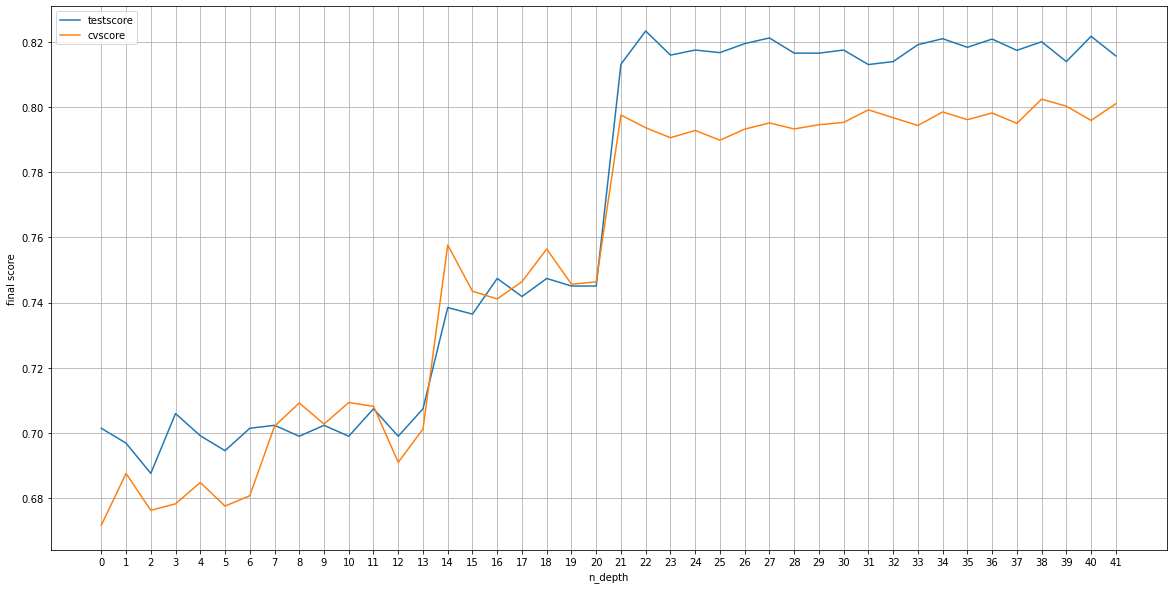

In [9]:
#劃出圖表，並以目測的方式找出各個出現峰值的超參數點，並將所有出現峰值的點的超參數都拿來train一次並將結果上傳網站
plt.figure(figsize=(20,10))
plt.plot(x,test_score['final_score'],label='testscore')
plt.plot(x,cv_score['final_score'],label='cvscore')
plt.xlabel('n_depth')
plt.xticks(x,x)
plt.ylabel('final score')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
#載入測試資料並且標準化
df_test=pd.read_csv('test.csv')
dx2=df_test[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]
dx_test2=pd.get_dummies(dx2,columns=['Geography','Gender'])
dx_test_std2=StandardScaler().fit_transform(dx_test2)

In [16]:
#紀錄每次上傳自網站的超參數的結果
forest=RandomForestClassifier(max_depth=9)
forest.fit(dx_train,dy_train)
prediction_forest=forest.predict(dx_test_std2)
df_forest_out=pd.DataFrame({
    "RowNumber":df_test['RowNumber'],
    "Exited":prediction_forest
})
df_forest_out.to_csv('forest_sample2.csv')
#acc: 0.8775
#precision: 0.8095
#fScore: 0.5812

In [12]:
#紀錄每次上傳自網站的超參數的結果
forest=RandomForestClassifier(max_depth=8,n_estimators=500)
forest.fit(dx_train,dy_train)
prediction_forest=forest.predict(dx_test_std2)
df_forest_out=pd.DataFrame({
    "RowNumber":df_test['RowNumber'],
    "Exited":prediction_forest
})
df_forest_out.to_csv('forest_sample2.csv')
#acc: 0.8750
#precision: 0.7907
#fScore: 0.5763

In [13]:
#紀錄每次上傳自網站的超參數的結果
forest=RandomForestClassifier(max_depth=9,n_estimators=300)
forest.fit(dx_train,dy_train)
prediction_forest=forest.predict(dx_test_std2)
df_forest_out=pd.DataFrame({
    "RowNumber":df_test['RowNumber'],
    "Exited":prediction_forest
})
df_forest_out.to_csv('forest_sample2.csv')
#acc: 0.8725
#precision: 0.7727
#fScore: 0.5714

In [14]:
#紀錄每次上傳自網站的超參數的結果
forest=RandomForestClassifier(max_depth=10,n_estimators=350)
forest.fit(dx_train,dy_train)
prediction_forest=forest.predict(dx_test_std2)
df_forest_out=pd.DataFrame({
    "RowNumber":df_test['RowNumber'],
    "Exited":prediction_forest
})
df_forest_out.to_csv('forest_sample2.csv')
#acc: 0.8700
#precision: 0.7556
#fScore: 0.5667

In [15]:
#紀錄每次上傳自網站的超參數的結果
forest=RandomForestClassifier(max_depth=10,n_estimators=150)
forest.fit(dx_train,dy_train)
prediction_forest=forest.predict(dx_test_std2)
df_forest_out=pd.DataFrame({
    "RowNumber":df_test['RowNumber'],
    "Exited":prediction_forest
})
df_forest_out.to_csv('forest_sample2.csv')
#acc: 0.8725
#precision: 0.7609
#fScore: 0.5785